In [4]:
#Import the necessary python Library
from __future__ import division
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np

from PIL import Image
import pickle

#importing Config file
import import_ipynb
import Config as c

cwd = os.getcwd()
%matplotlib inline

importing Jupyter notebook from Config.ipynb


In [5]:
# Function to show an input image
def show_image(image, cmap=None):
    cols = 2
    rows = (len(image)+1)//cols
    
    plt.figure(figsize=(15, 12))
    for i, image in enumerate(image):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

# image is expected be in RGB color space# image 
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8(c.lower_white)
    upper = np.uint8(c.upper_white)
    white_mask = cv2.inRange(image, lower, upper)
    
    # yellow color mask
    lower = np.uint8(c.lower_yellow)
    upper = np.uint8(c.upper_yellow)
    yellow_mask = cv2.inRange(image, lower, upper)
    
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

#Method to convert an input image to grey scale
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#Method to apply Canny transform to an input image for edge detection
def detect_edges(image, low_threshold=c.low_threshold, high_threshold=c.high_threshold):
    int_img = cv2.GaussianBlur(image, (c.blur_low,c.blur_high),0)
    #plt.imshow(int_img)
    return cv2.Canny(int_img, low_threshold, high_threshold)

#Method to apply houghline rtanform to an input image for lines
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=c.rho, theta=np.pi/c.divisor, threshold=c.threshold_value, minLineLength=c.houghline_minlinelength, maxLineGap=c.houghline_maxlinegap)

# Method to show the lines returned from the houghline tranform
def draw_lines(image, lines, color=[255, 0, 0], thickness=c.draw_lines_thickness, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    cleaned = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(y2-y1) <=c.lines_y_threshold and abs(x2-x1) >=c.lines_x_threshold1 and abs(x2-x1) <= c.lines_x_threshold2:
                cleaned.append((x1,y1,x2,y2))
                cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    #print(" No lines detected: ", len(cleaned))
    return image

#Method to identify the number of rectangular lanes in the parking lot
def identify_blocks(image, lines, make_copy=True):
    if make_copy:
        new_image = np.copy(image)
       
    #Step 1: Create a clean list of lines
    cleaned = []
    gap_list = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(y2-y1) <=c.lines_y_threshold and abs(x2-x1) >=c.lines_x_threshold1 and abs(x2-x1) <= c.lines_x_threshold2:
                cleaned.append((x1,y1,x2,y2))
                gap_list.append((y1))
    
    #Step 2: Sort cleaned by x1 position
    import operator
    list1 = sorted(cleaned, key=operator.itemgetter(0, 1))    
    #Step 3: Find clusters of x1 close together - clust_dist apart
    clusters = {}
    dIndex = 0   
    clus_dist = c.clust_dist

    for i in range(len(list1) - 1):
        distance = abs(list1[i+1][0] - list1[i][0])
        if distance <= clus_dist:
            if not dIndex in clusters.keys(): clusters[dIndex] = []
            clusters[dIndex].append(list1[i])
            clusters[dIndex].append(list1[i + 1])

        else:
            dIndex += 1
    
    #Step 4: Identify coordinates of rectangle around this cluster
    rects = {}
    i = 0
    for key in clusters:
        all_list = clusters[key]
        cleaned = list(set(all_list))
        if len(cleaned) > c.threshold_value:
            
            cleaned = sorted(cleaned, key=lambda tup: tup[1])
            avg_y1 = cleaned[0][1]
            avg_y2 = cleaned[-1][1]
            avg_x1 = c.max_image_width #put the max width of the image
            avg_x2 = 0
            for tup in cleaned:
                avg_x1 = min(avg_x1, tup[0])
                avg_x2 = max(avg_x2, tup[2])
            avg_x1 = avg_x1 + c.adjust_dict[i+1][0]
            avg_y1 = avg_y1 + c.adjust_dict[i+1][1]
            avg_x2 = avg_x2 + c.adjust_dict[i+1][2]
            avg_y2 = avg_y2 + c.adjust_dict[i+1][3]
            rects[i] = (avg_x1, avg_y1, avg_x2, avg_y2)
            i += 1
            
    print("Num Parking Lanes: ", len(rects))
    
    #Step 5: Draw the rectangles on the image 
    for key in rects:     
        tup_topLeft = (int(rects[key][0]), int(rects[key][1]))
        tup_botRight = (int(rects[key][2]), int(rects[key][3]))
        cv2.rectangle(new_image, tup_topLeft,tup_botRight,c.rect_color,3)
    return new_image, rects


# Identify each spot and count num of parking spaces
# Based on width of each parking line segment into individual spots
# Draw a visualization of all parking spaces
def draw_parking(image, rects, make_copy = True, color=[255, 0, 0], thickness=c.draw_lines_thickness, save = True):
    if make_copy:
        new_image = np.copy(image)
    gap = c.gap
    spot_dict = {} # maps each parking ID to its coords
    tot_spots = 0
    gap_cnt = 1
    for key in rects:
        # Horizontal lines
        tup = rects[key]
        x1 = int(tup[0])
        x2 = int(tup[2])
        y1 = int(tup[1])
        y2 = int(tup[3])
        cv2.rectangle(new_image, (x1, y1),(x2,y2),(0,255,0),2)
      
        num_splits = int(abs(y2-y1)//gap)
        
        
        #print(num_splits)
        for i in range(0, num_splits+1):
            y = int(y1 + i*gap)
            cv2.line(new_image, (x1, y), (x2, y), color, thickness)
            
        for i in range(0, num_splits+1):
            cur_len = len(spot_dict)
            y = int(y1 + i*gap)
            x = int(x1)
            if (y2-y) > round(gap/2):
                tot_spots += 1
                spot_dict[(x1, y, x2, y+gap)] = cur_len +1
            
    
    print("total parking spaces: ", tot_spots)
    if save:
        filename = 'test.jpg'
        cv2.imwrite(filename, new_image)
    return new_image, spot_dict

# Ctrate a mask using the vertices and apply to the image
def filter_region(image, vertices):
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

# Only shows the region which need to be considered and masks rest in black    
def select_region(image):
    rows, cols = image.shape[:2]

    vertices_scale_x = [i * cols for i in c.vertices_scale_x]
    vertices_scale_y = [i * rows for i in c.vertices_scale_y]
    input_vertices = list(zip(vertices_scale_x,vertices_scale_y))
    vertices = np.array([input_vertices], dtype=np.int32)
    return filter_region(image, vertices)

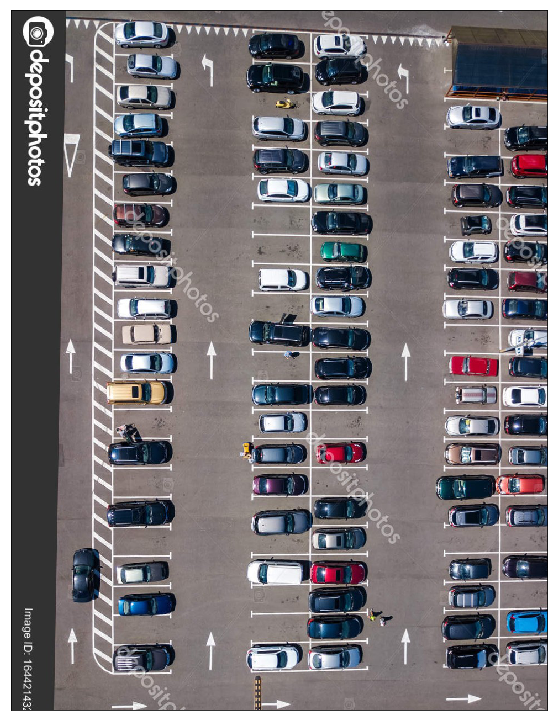

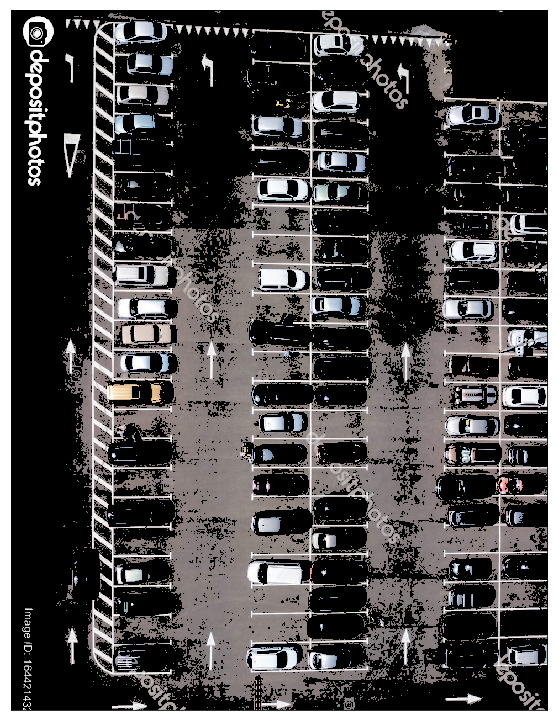

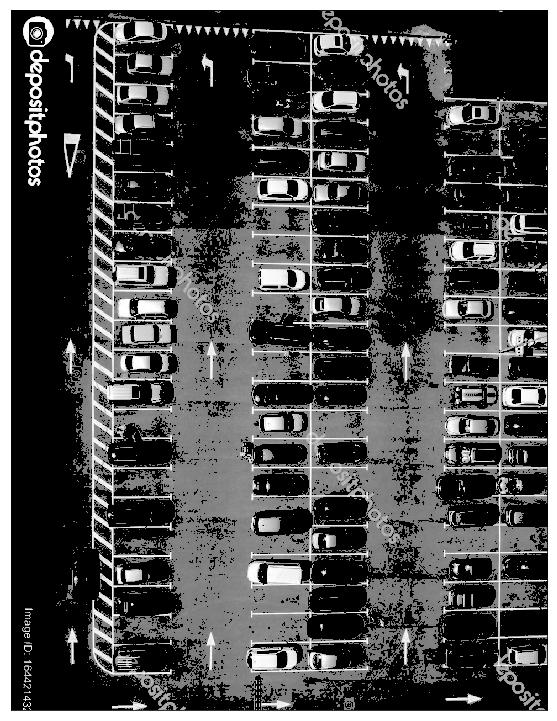

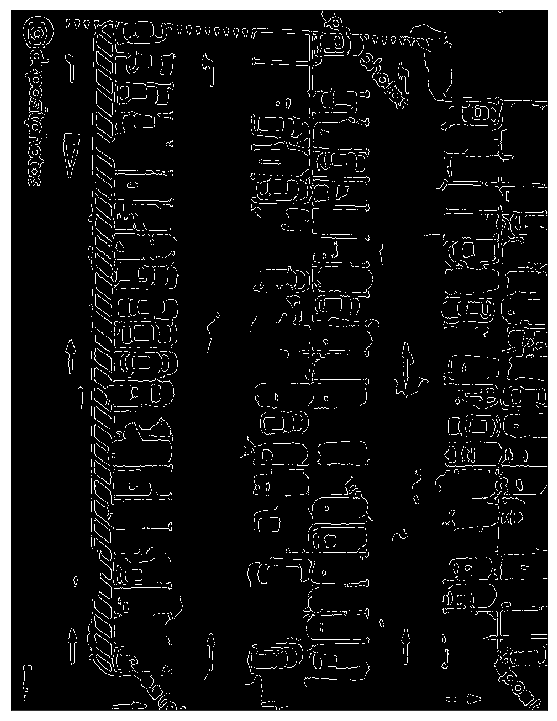

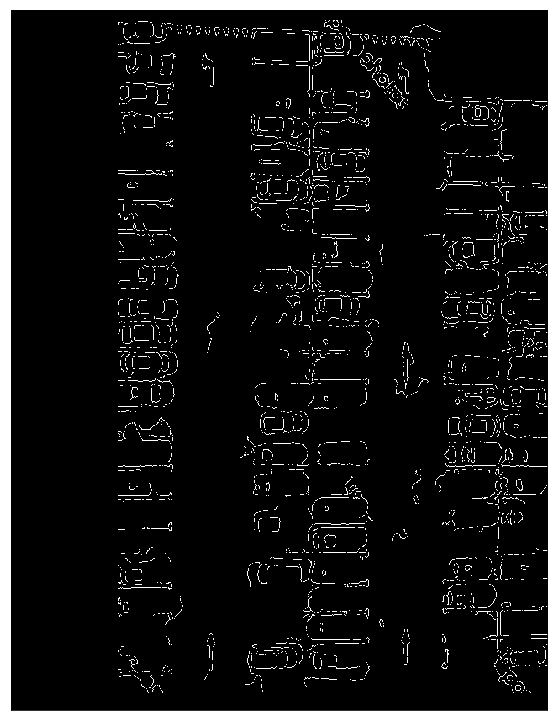

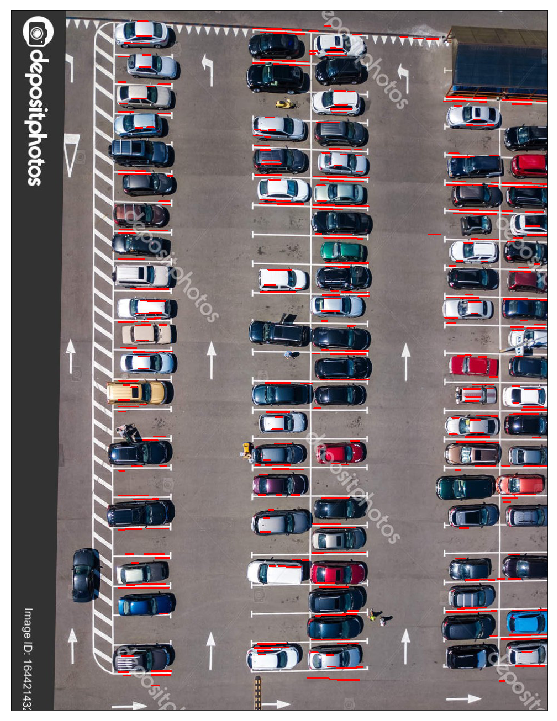

Num Parking Lanes:  5


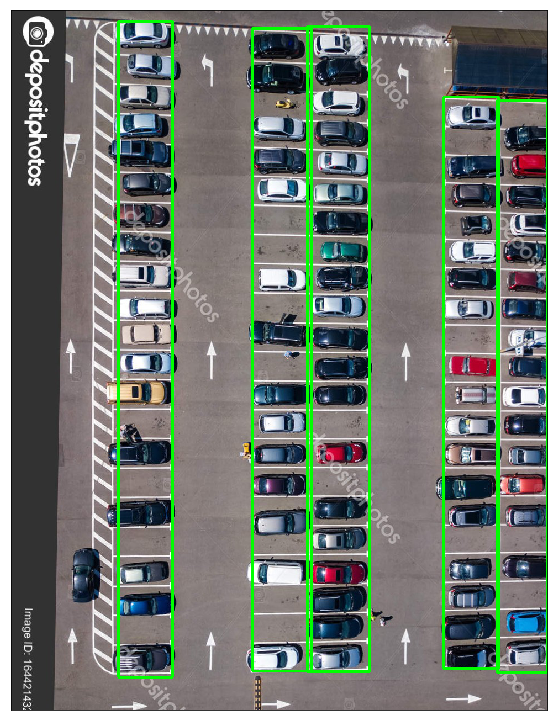

total parking spaces:  106


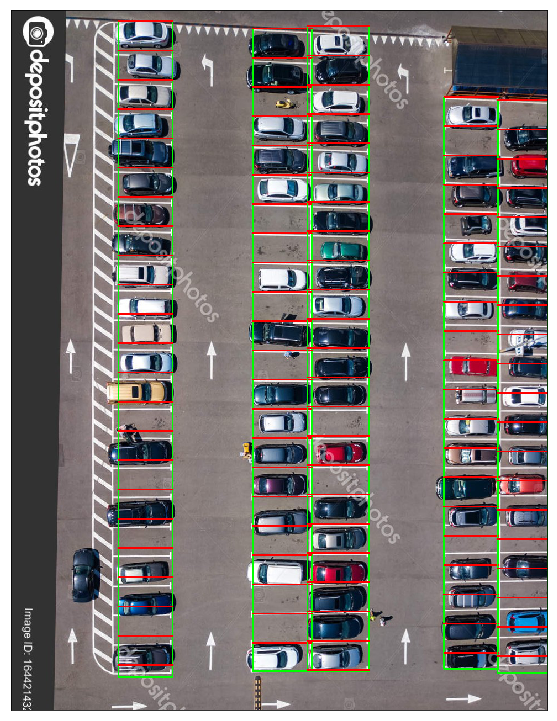

106


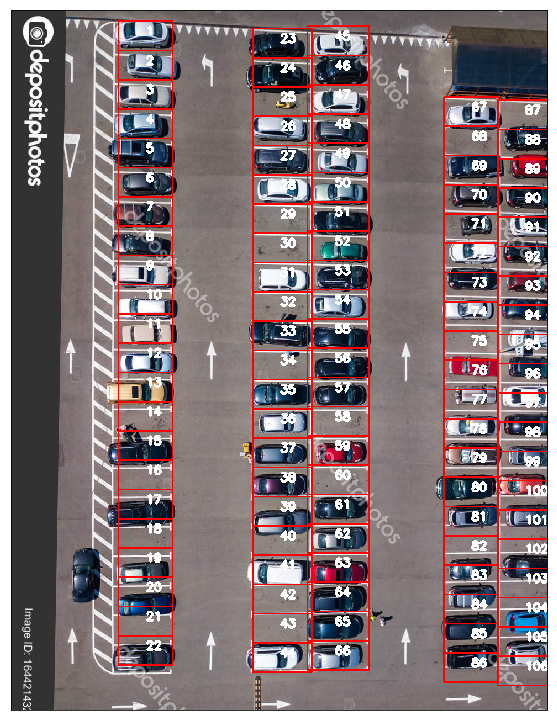

In [6]:
# Load the Image
input_image = [plt.imread(path) for path in glob.glob(c.img_path)]
show_image(input_image)

# Convert the image to RGB Color space
white_yellow_image = list(map(select_rgb_white_yellow, input_image))
show_image(white_yellow_image)

#Convert the image to grey scale
grey_image = list(map(convert_gray_scale, white_yellow_image))
show_image(grey_image)

#Apply gaussian blur and canny transform 
edge_image = list(map(lambda image: detect_edges(image), grey_image))
show_image(edge_image)

# Find out the region of interest
roi_image = list(map(select_region, edge_image))
show_image(roi_image)

# Hough line transform applied to input images to get the list of lines
list_of_lines = list(map(hough_lines, roi_image))
#Draw the lines on the image
line_image = []
for image, lines in zip(input_image, list_of_lines):
    line_image.append(draw_lines(image, lines))
show_image(line_image)

# Store the co-ordinates of the parking block/lanes
rect_image = []
rect_coords = []
for image, lines in zip(input_image, list_of_lines):
    new_image, rects = identify_blocks(image, lines)
    rect_image.append(new_image)
    rect_coords.append(rects)  
show_image(rect_image)

# identify and store the co-ordinate of the individual parking spots
delineated = []
spot_pos = []
for image, rects in zip(input_image, rect_coords):
    new_image, spot_dict = draw_parking(image, rects)
    delineated.append(new_image)
    spot_pos.append(spot_dict) 
show_image(delineated)

#Store the parking slot co-ordinates in the spot dictionary and store ot s pickle file
final_spot_dict = spot_pos[0]
print(len(final_spot_dict))
with open(c.pickle_file, 'wb') as handle:
    pickle.dump(final_spot_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

def assign_spots_map(image, spot_dict=final_spot_dict, make_copy = True, color=[255, 0, 0], thickness=c.draw_lines_thickness):
    if make_copy:
        new_image = np.copy(image)
    spot_count = 1
    for spot in spot_dict.keys():
        (x1, y1, x2, y2) = spot
        cv2.rectangle(new_image, (int(x1),int(y1)), (int(x2),int(y2)), color, thickness)
        cv2.putText(new_image,"%d  "%spot_count, (x1+50, y1+25),
        cv2.FONT_HERSHEY_SIMPLEX,0.7, c.font_color, c.channels)
        spot_count += 1
    return new_image

#Show the image with the final identified slots
marked_spot_image = list(map(assign_spots_map, input_image))
show_image(marked_spot_image)